# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

- What Augs are useful
- What Text models perform best

In [3]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.0, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.0}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# images = list(data["train"].img) + list(data["test"].img)
# pd.DataFrame({"img":images}).to_csv("image.csv", header=None, index=None)

# ImageAugment([0.2, 0.5, 0.3])


In [4]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [5]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [6]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# BERT Models

## Non Ensemble

Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.554644 LR = 0.00000348


Proba       Preds    
         min   max   min max
Labels                      
0      0.173 0.446     0   0
1      0.120 0.445     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.314,"[0.685528576374054, 0.31447145342826843]",0,1,0.293,"[0.7067979574203491, 0.29320207238197327]",0,1,0.407,"[0.5933736562728882, 0.40662631392478943]",0,0
1,0.245,"[0.7552762031555176, 0.244723841547966]",0,1,0.226,"[0.7743275165557861, 0.22567248344421387]",0,0,0.280,"[0.7203682661056519, 0.27963173389434814]",0,0
2,0.220,"[0.7804115414619446, 0.21958844363689423]",0,1,0.299,"[0.7006900310516357, 0.29930993914604187]",0,0,0.305,"[0.6945099234580994, 0.30549007654190063]",0,1
3,0.346,"[0.6537903547286987, 0.34620964527130127]",0,1,0.289,"[0.71062833070755, 0.28937169909477234]",0,0,0.242,"[0.7577943801879883, 0.2422056347131729]",0,1
4,0.287,"[0.7126322984695435, 0.28736767172813416]",0,1,0.331,"[0.6686639785766602, 0.33133605122566223]",0,0,0.290,"[0.7096232175827026, 0.29037681221961975]",0,1


scores =  {'map': '0.4957', 'acc': '0.5000', 'auc': '0.5058'}
Epoch =  1 Train = 0.524517 Val = 0.505832



Epoch =  2 Loss = 0.506561 LR = 0.00000697



Epoch =  3 Loss = 0.486112 LR = 0.00001045



Epoch =  4 Loss = 0.456884 LR = 0.00001393


Proba       Preds    
         min   max   min max
Labels                      
0      0.265 0.572     0   1
1      0.233 0.572     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.399,"[0.6008911728858948, 0.3991088569164276]",0,0,0.400,"[0.6001883149147034, 0.39981162548065186]",0,1,0.413,"[0.586759626865387, 0.41324031352996826]",0,0
1,0.360,"[0.640186071395874, 0.3598138988018036]",0,1,0.390,"[0.6102212071418762, 0.3897787928581238]",0,1,0.334,"[0.6664968132972717, 0.33350321650505066]",0,1
2,0.428,"[0.5724837779998779, 0.4275161921977997]",0,0,0.370,"[0.6302298903465271, 0.3697701096534729]",0,0,0.344,"[0.6564380526542664, 0.34356194734573364]",0,1
3,0.273,"[0.7272012233734131, 0.2727987766265869]",0,1,0.360,"[0.640186071395874, 0.3598138988018036]",0,1,0.363,"[0.63680499792099, 0.3631950318813324]",0,0
4,0.447,"[0.5527811646461487, 0.4472188651561737]",0,1,0.326,"[0.6736212372779846, 0.32637879252433777]",0,1,0.358,"[0.641983687877655, 0.3580162823200226]",0,1


scores =  {'map': '0.5453', 'acc': '0.5020', 'auc': '0.5569'}
Epoch =  4 Train = 0.646950 Val = 0.556880



Epoch =  5 Loss = 0.455823 LR = 0.00001742



Epoch =  6 Loss = 0.452754 LR = 0.00002090



Epoch =  7 Loss = 0.451767 LR = 0.00002439


Proba       Preds    
         min   max   min max
Labels                      
0      0.300 0.767     0   1
1      0.318 0.767     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.482,"[0.5183023810386658, 0.4816976487636566]",0,1,0.413,"[0.5869964361190796, 0.4130035638809204]",0,1,0.578,"[0.4222663640975952, 0.5777336359024048]",1,1
1,0.585,"[0.41513592004776, 0.58486407995224]",1,0,0.581,"[0.4194101393222809, 0.5805898904800415]",1,1,0.581,"[0.4194101393222809, 0.5805898904800415]",1,0
2,0.579,"[0.42107561230659485, 0.5789243578910828]",1,1,0.680,"[0.32039588689804077, 0.6796041131019592]",1,1,0.576,"[0.4241734743118286, 0.5758265852928162]",1,0
3,0.367,"[0.632729709148407, 0.3672703206539154]",0,1,0.397,"[0.6034646034240723, 0.3965354561805725]",0,1,0.594,"[0.4056841731071472, 0.5943158864974976]",1,1
4,0.478,"[0.5224458575248718, 0.47755417227745056]",0,1,0.562,"[0.4380638599395752, 0.56193608045578]",1,1,0.574,"[0.4258440136909485, 0.5741560459136963]",1,1


scores =  {'map': '0.6050', 'acc': '0.5560', 'auc': '0.6083'}
Epoch =  7 Train = 0.722376 Val = 0.608320



Epoch =  8 Loss = 0.412344 LR = 0.00002787



Epoch =  9 Loss = 0.431324 LR = 0.00003135


Proba       Preds    
         min   max   min max
Labels                      
0      0.140 0.750     0   1
1      0.187 0.750     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.230,"[0.7704647779464722, 0.22953520715236664]",0,0,0.448,"[0.5515737533569336, 0.4484262764453888]",0,1,0.365,"[0.6352224349975586, 0.3647775948047638]",0,1
1,0.451,"[0.5489153265953064, 0.4510846734046936]",0,1,0.447,"[0.553022563457489, 0.4469774663448334]",0,0,0.253,"[0.7474316954612732, 0.2525683641433716]",0,1
2,0.327,"[0.6734064817428589, 0.3265935182571411]",0,0,0.246,"[0.753829300403595, 0.24617071449756622]",0,1,0.318,"[0.6819385886192322, 0.31806138157844543]",0,0
3,0.342,"[0.6575384140014648, 0.34246155619621277]",0,0,0.233,"[0.7673413753509521, 0.23265865445137024]",0,0,0.543,"[0.45665207505226135, 0.543347954750061]",1,1
4,0.415,"[0.5851011276245117, 0.4148988127708435]",0,1,0.276,"[0.724090576171875, 0.275909423828125]",0,0,0.509,"[0.49121183156967163, 0.5087881684303284]",1,1


scores =  {'map': '0.6065', 'acc': '0.5420', 'auc': '0.6249'}
Epoch =  9 Train = 0.750745 Val = 0.624872



Epoch =  10 Loss = 0.444103 LR = 0.00003484



Epoch =  11 Loss = 0.430771 LR = 0.00003832


Proba       Preds    
         min   max   min max
Labels                      
0      0.115 0.661     0   1
1      0.150 0.661     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.339,"[0.6608293652534485, 0.3391706645488739]",0,0,0.239,"[0.7613611221313477, 0.23863890767097473]",0,1,0.271,"[0.7285552024841309, 0.27144479751586914]",0,0
1,0.445,"[0.5549529194831848, 0.4450470805168152]",0,1,0.241,"[0.7585106492042542, 0.24148939549922943]",0,0,0.353,"[0.6469064354896545, 0.35309356451034546]",0,0
2,0.275,"[0.7252596020698547, 0.2747403681278229]",0,0,0.324,"[0.6764061450958252, 0.32359379529953003]",0,1,0.245,"[0.7554566264152527, 0.24454337358474731]",0,0
3,0.568,"[0.4315841794013977, 0.5684158205986023]",1,1,0.374,"[0.6256668567657471, 0.37433314323425293]",0,1,0.495,"[0.5051267743110657, 0.4948732256889343]",0,1
4,0.160,"[0.8402590155601501, 0.15974101424217224]",0,0,0.307,"[0.6934729218482971, 0.3065270185470581]",0,1,0.207,"[0.793105959892273, 0.20689405500888824]",0,0


scores =  {'map': '0.6015', 'acc': '0.5240', 'auc': '0.6162'}
Epoch =  11 Train = 0.763855 Val = 0.616192



Epoch =  12 Loss = 0.440253 LR = 0.00004180



Epoch =  13 Loss = 0.408258 LR = 0.00004529



Epoch =  14 Loss = 0.407293 LR = 0.00004877


Proba       Preds    
         min   max   min max
Labels                      
0      0.179 0.860     0   1
1      0.246 0.860     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.490,"[0.5104964971542358, 0.48950350284576416]",0,0,0.397,"[0.6032308340072632, 0.3967691659927368]",0,0,0.499,"[0.501220703125, 0.498779296875]",0,1
1,0.495,"[0.5048826932907104, 0.49511733651161194]",0,1,0.605,"[0.3953675925731659, 0.6046323776245117]",1,0,0.816,"[0.18359361588954926, 0.8164063692092896]",1,1
2,0.356,"[0.6440012454986572, 0.3559987246990204]",0,1,0.409,"[0.590779185295105, 0.40922078490257263]",0,0,0.566,"[0.43374159932136536, 0.5662583708763123]",1,1
3,0.826,"[0.17356818914413452, 0.8264318704605103]",1,1,0.532,"[0.46830424666404724, 0.5316957235336304]",1,1,0.382,"[0.6180891394615173, 0.38191086053848267]",0,1
4,0.667,"[0.332852303981781, 0.6671476364135742]",1,0,0.420,"[0.5801141858100891, 0.4198857843875885]",0,0,0.395,"[0.6050992012023926, 0.3949008285999298]",0,1


scores =  {'map': '0.6078', 'acc': '0.5960', 'auc': '0.6384'}
Epoch =  14 Train = 0.777836 Val = 0.638448



Epoch =  15 Loss = 0.424705 LR = 0.00004995



Epoch =  16 Loss = 0.396453 LR = 0.00004970



Epoch =  17 Loss = 0.397149 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.106 0.714     0   1
1      0.169 0.736     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.287,"[0.7134315967559814, 0.28656837344169617]",0,0,0.410,"[0.5895982384681702, 0.41040176153182983]",0,1,0.442,"[0.5583269596099854, 0.44167301058769226]",0,1
1,0.332,"[0.6675812602043152, 0.3324187397956848]",0,1,0.414,"[0.5862860083580017, 0.4137139916419983]",0,0,0.428,"[0.5724837779998779, 0.4275161921977997]",0,1
2,0.358,"[0.6422081589698792, 0.35779187083244324]",0,0,0.318,"[0.6815148591995239, 0.3184851408004761]",0,1,0.375,"[0.6245225667953491, 0.3754774332046509]",0,1
3,0.398,"[0.6020615696907043, 0.39793840050697327]",0,0,0.300,"[0.6996649503707886, 0.30033499002456665]",0,1,0.714,"[0.2859697937965393, 0.7140302062034607]",1,1
4,0.462,"[0.5382551550865173, 0.46174484491348267]",0,1,0.305,"[0.6953380107879639, 0.30466192960739136]",0,0,0.290,"[0.710427463054657, 0.289572536945343]",0,1


scores =  {'map': '0.6081', 'acc': '0.5380', 'auc': '0.6316'}
Epoch =  17 Train = 0.795230 Val = 0.631552



Epoch =  18 Loss = 0.407629 LR = 0.00004856



Epoch =  19 Loss = 0.389708 LR = 0.00004768


Proba       Preds    
         min   max   min max
Labels                      
0      0.123 0.763     0   1
1      0.198 0.776     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.372,"[0.6277230381965637, 0.3722769320011139]",0,0,0.249,"[0.7512834072113037, 0.24871662259101868]",0,0,0.352,"[0.6480209827423096, 0.35197898745536804]",0,0
1,0.379,"[0.6210813522338867, 0.3789186179637909]",0,0,0.487,"[0.5131805539131165, 0.48681944608688354]",0,0,0.590,"[0.4099292457103729, 0.5900707840919495]",1,0
2,0.434,"[0.5660185217857361, 0.4339814782142639]",0,1,0.530,"[0.4700067639350891, 0.5299932360649109]",1,0,0.346,"[0.6535692811012268, 0.3464307188987732]",0,0
3,0.325,"[0.6749081611633301, 0.3250918686389923]",0,1,0.490,"[0.5102524757385254, 0.489747554063797]",0,0,0.519,"[0.4809662103652954, 0.5190337300300598]",1,0
4,0.486,"[0.5136684775352478, 0.4863315224647522]",0,1,0.390,"[0.6099889278411865, 0.39001110196113586]",0,0,0.530,"[0.46976351737976074, 0.530236542224884]",1,1


scores =  {'map': '0.6180', 'acc': '0.5700', 'auc': '0.6496'}
Epoch =  19 Train = 0.804007 Val = 0.649552



Epoch =  20 Loss = 0.377381 LR = 0.00004660



Epoch =  21 Loss = 0.381497 LR = 0.00004534



Epoch =  22 Loss = 0.379923 LR = 0.00004389



Epoch =  23 Loss = 0.371415 LR = 0.00004229


Proba       Preds    
         min   max   min max
Labels                      
0      0.086 0.758     0   1
1      0.212 0.764     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.429,"[0.571049153804779, 0.42895087599754333]",0,0,0.529,"[0.47122323513031006, 0.5287767648696899]",1,0,0.592,"[0.40756916999816895, 0.5924307703971863]",1,0
1,0.377,"[0.6226887702941895, 0.37731117010116577]",0,0,0.463,"[0.5367985367774963, 0.4632014036178589]",0,1,0.426,"[0.5741560459136963, 0.4258440136909485]",0,1
2,0.363,"[0.6374822854995728, 0.36251774430274963]",0,1,0.755,"[0.244723841547966, 0.7552762031555176]",1,0,0.733,"[0.26702573895454407, 0.7329742908477783]",1,1
3,0.218,"[0.7819972634315491, 0.21800270676612854]",0,0,0.586,"[0.4139508903026581, 0.5860491394996643]",1,1,0.488,"[0.5122045874595642, 0.4877953827381134]",0,0
4,0.524,"[0.47609245777130127, 0.523907482624054]",1,0,0.359,"[0.6410853862762451, 0.3589146137237549]",0,0,0.539,"[0.46077412366867065, 0.5392258763313293]",1,0


scores =  {'map': '0.6165', 'acc': '0.5740', 'auc': '0.6437'}
Epoch =  23 Train = 0.817965 Val = 0.643672



Epoch =  24 Loss = 0.378725 LR = 0.00004053



Epoch =  25 Loss = 0.378715 LR = 0.00003863



Epoch =  26 Loss = 0.372483 LR = 0.00003662



Epoch =  27 Loss = 0.379114 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.054 0.762     0   1
1      0.162 0.804     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.202,"[0.7975568175315857, 0.2024431824684143]",0,0,0.252,"[0.7483522891998291, 0.2516477108001709]",0,1,0.183,"[0.8169911503791809, 0.1830088496208191]",0,0
1,0.233,"[0.7671669721603394, 0.23283304274082184]",0,0,0.379,"[0.6206216216087341, 0.37937837839126587]",0,0,0.630,"[0.37022536993026733, 0.6297746300697327]",1,0
2,0.481,"[0.5187900066375732, 0.48121002316474915]",0,0,0.334,"[0.666279673576355, 0.33372029662132263]",0,1,0.252,"[0.7478001117706299, 0.25219982862472534]",0,1
3,0.397,"[0.6034646034240723, 0.3965354561805725]",0,0,0.472,"[0.5275599360466003, 0.47244003415107727]",0,1,0.425,"[0.5751108527183533, 0.4248892068862915]",0,1
4,0.454,"[0.5462540984153748, 0.45374590158462524]",0,0,0.373,"[0.6274948120117188, 0.37250518798828125]",0,1,0.363,"[0.6374822854995728, 0.36251774430274963]",0,1


scores =  {'map': '0.6189', 'acc': '0.5480', 'auc': '0.6475'}
Epoch =  27 Train = 0.831980 Val = 0.647504



Epoch =  28 Loss = 0.368196 LR = 0.00003231



Epoch =  29 Loss = 0.357652 LR = 0.00003005



Epoch =  30 Loss = 0.364323 LR = 0.00002774



Epoch =  31 Loss = 0.371041 LR = 0.00002541


Proba       Preds    
         min   max   min max
Labels                      
0      0.095 0.833     0   1
1      0.234 0.835     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.437,"[0.5628975033760071, 0.4371025562286377]",0,0,0.475,"[0.5251253247261047, 0.47487467527389526]",0,0,0.327,"[0.6727617979049683, 0.32723814249038696]",0,1
1,0.528,"[0.4717099368572235, 0.5282900333404541]",1,1,0.696,"[0.303628534078598, 0.6963714361190796]",1,0,0.478,"[0.5224458575248718, 0.47755417227745056]",0,0
2,0.597,"[0.40286189317703247, 0.5971381068229675]",1,1,0.430,"[0.5698526501655579, 0.43014732003211975]",0,0,0.609,"[0.39094078540802, 0.60905921459198]",1,1
3,0.603,"[0.397236704826355, 0.6027632355690002]",1,1,0.451,"[0.5493988990783691, 0.45060113072395325]",0,0,0.436,"[0.5640984773635864, 0.4359014928340912]",0,0
4,0.348,"[0.6524628400802612, 0.347537100315094]",0,1,0.634,"[0.3663630187511444, 0.633637011051178]",1,1,0.506,"[0.4941408932209015, 0.5058591365814209]",1,1


scores =  {'map': '0.6135', 'acc': '0.5860', 'auc': '0.6466'}
Epoch =  31 Train = 0.840741 Val = 0.646560



Epoch =  32 Loss = 0.358367 LR = 0.00002308



Epoch =  33 Loss = 0.361942 LR = 0.00002076



Epoch =  34 Loss = 0.358877 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.067 0.802     0   1
1      0.199 0.794     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.350,"[0.650245189666748, 0.34975478053092957]",0,0,0.567,"[0.43254271149635315, 0.5674573183059692]",1,1,0.419,"[0.5805898904800415, 0.4194101393222809]",0,0
1,0.407,"[0.5929023027420044, 0.4070976674556732]",0,1,0.185,"[0.814643383026123, 0.18535663187503815]",0,0,0.482,"[0.5175709128379822, 0.4824290871620178]",0,0
2,0.556,"[0.44432365894317627, 0.5556763410568237]",1,1,0.557,"[0.443359375, 0.556640625]",1,1,0.544,"[0.45568299293518066, 0.5443170070648193]",1,0
3,0.265,"[0.7354516386985779, 0.26454830169677734]",0,0,0.334,"[0.6656279563903809, 0.33437207341194153]",0,1,0.449,"[0.5506073832511902, 0.4493926167488098]",0,0
4,0.566,"[0.4342213571071625, 0.5657786130905151]",1,0,0.544,"[0.45568299293518066, 0.5443170070648193]",1,0,0.321,"[0.6785399913787842, 0.32145997881889343]",0,0


scores =  {'map': '0.6045', 'acc': '0.5660', 'auc': '0.6374'}
Epoch =  34 Train = 0.846423 Val = 0.637368



Epoch =  35 Loss = 0.354819 LR = 0.00001626



Epoch =  36 Loss = 0.358663 LR = 0.00001412


Exception for:  keyboard | ! ' ' ' ' | ['char_insert' 'one_third_cut' 'sentence_shuffle' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  37 Loss = 0.358382 LR = 0.00001207


Proba       Preds    
         min   max   min max
Labels                      
0      0.053 0.771     0   1
1      0.171 0.785     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.532,"[0.4675748348236084, 0.5324251055717468]",1,1,0.422,"[0.5777336359024048, 0.4222663640975952]",0,1,0.254,"[0.7461389899253845, 0.2538610100746155]",0,1
1,0.279,"[0.7209580540657043, 0.27904197573661804]",0,1,0.369,"[0.6311396956443787, 0.36886027455329895]",0,1,0.220,"[0.7798252701759338, 0.22017472982406616]",0,1
2,0.318,"[0.6817268133163452, 0.3182732164859772]",0,1,0.416,"[0.5839152932167053, 0.4160846769809723]",0,0,0.340,"[0.6597340106964111, 0.3402659296989441]",0,1
3,0.527,"[0.47292691469192505, 0.5270731449127197]",1,0,0.356,"[0.6442251205444336, 0.3557748794555664]",0,0,0.269,"[0.7306743860244751, 0.2693255841732025]",0,1
4,0.549,"[0.45132651925086975, 0.5486735105514526]",1,0,0.365,"[0.635448694229126, 0.3645513355731964]",0,1,0.565,"[0.43542131781578064, 0.564578652381897]",1,0


scores =  {'map': '0.6116', 'acc': '0.5560', 'auc': '0.6398'}
Epoch =  37 Train = 0.851975 Val = 0.639840



Epoch =  38 Loss = 0.367407 LR = 0.00001013



Epoch =  39 Loss = 0.357125 LR = 0.00000832



Epoch =  40 Loss = 0.347471 LR = 0.00000666



Epoch =  41 Loss = 0.349816 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.065 0.815     0   1
1      0.217 0.841     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.508,"[0.4916999638080597, 0.5083000063896179]",1,0,0.360,"[0.6404110193252563, 0.35958898067474365]",0,0,0.628,"[0.37159258127212524, 0.6284074187278748]",1,1
1,0.714,"[0.2855711877346039, 0.7144288420677185]",1,1,0.532,"[0.4675748348236084, 0.5324251055717468]",1,1,0.505,"[0.49511733651161194, 0.5048826932907104]",1,1
2,0.424,"[0.5758265852928162, 0.4241734743118286]",0,1,0.428,"[0.5722447633743286, 0.427755206823349]",0,1,0.392,"[0.6078959703445435, 0.39210402965545654]",0,1
3,0.328,"[0.672331690788269, 0.32766830921173096]",0,0,0.508,"[0.4916999638080597, 0.5083000063896179]",1,1,0.260,"[0.7396105527877808, 0.26038944721221924]",0,1
4,0.615,"[0.38514333963394165, 0.6148566007614136]",1,1,0.452,"[0.547947883605957, 0.4520520865917206]",0,1,0.500,"[0.4995116889476776, 0.50048828125]",1,0


scores =  {'map': '0.6166', 'acc': '0.5840', 'auc': '0.6434'}
Epoch =  41 Train = 0.854303 Val = 0.643408



Epoch =  42 Loss = 0.353729 LR = 0.00000382



Epoch =  43 Loss = 0.350354 LR = 0.00000268



Epoch =  44 Loss = 0.353405 LR = 0.00000172


Proba       Preds    
         min   max   min max
Labels                      
0      0.053 0.784     0   1
1      0.181 0.823     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.501,"[0.498779296875, 0.501220703125]",1,0,0.495,"[0.5051267743110657, 0.4948732256889343]",0,0,0.582,"[0.41774648427963257, 0.5822535157203674]",1,1
1,0.405,"[0.5947866439819336, 0.405213326215744]",0,0,0.290,"[0.7096232175827026, 0.29037681221961975]",0,0,0.485,"[0.5153760313987732, 0.4846239686012268]",0,1
2,0.293,"[0.7065955400466919, 0.2934044599533081]",0,1,0.552,"[0.44794324040412903, 0.5520567893981934]",1,0,0.264,"[0.7360212802886963, 0.2639786899089813]",0,1
3,0.375,"[0.6245225667953491, 0.3754774332046509]",0,0,0.520,"[0.47950369119644165, 0.5204963088035583]",1,0,0.568,"[0.4318237602710724, 0.5681762099266052]",1,1
4,0.693,"[0.3073579967021942, 0.6926419734954834]",1,0,0.290,"[0.7096232175827026, 0.29037681221961975]",0,1,0.205,"[0.7954992651939392, 0.2045007199048996]",0,0


scores =  {'map': '0.6202', 'acc': '0.5760', 'auc': '0.6469'}
Epoch =  44 Train = 0.855807 Val = 0.646856



Epoch =  45 Loss = 0.356233 LR = 0.00000097



Epoch =  46 Loss = 0.349479 LR = 0.00000043



Epoch =  47 Loss = 0.352962 LR = 0.00000011


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.803     0   1
1      0.197 0.838     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.525,"[0.4746311604976654, 0.5253688097000122]",1,1,0.455,"[0.5450435876846313, 0.45495644211769104]",0,0,0.270,"[0.7300974726676941, 0.2699024975299835]",0,0
1,0.490,"[0.5102524757385254, 0.489747554063797]",0,1,0.671,"[0.3293916881084442, 0.6706082820892334]",1,0,0.546,"[0.45374590158462524, 0.5462540984153748]",1,0
2,0.330,"[0.6695287823677063, 0.3304711878299713]",0,1,0.241,"[0.7590468525886536, 0.24095314741134644]",0,0,0.427,"[0.5732006430625916, 0.42679932713508606]",0,0
3,0.432,"[0.5684158205986023, 0.4315841794013977]",0,1,0.608,"[0.39187130331993103, 0.6081287264823914]",1,0,0.532,"[0.46806108951568604, 0.5319388508796692]",1,1
4,0.533,"[0.4668456017971039, 0.5331543684005737]",1,1,0.482,"[0.5175709128379822, 0.4824290871620178]",0,1,0.591,"[0.4089847207069397, 0.5910152792930603]",1,0


scores =  {'map': '0.6207', 'acc': '0.5740', 'auc': '0.6471'}
Epoch =  47 Train = 0.856103 Val = 0.647072



Epoch =  48 Loss = 0.354972 LR = 0.00000000



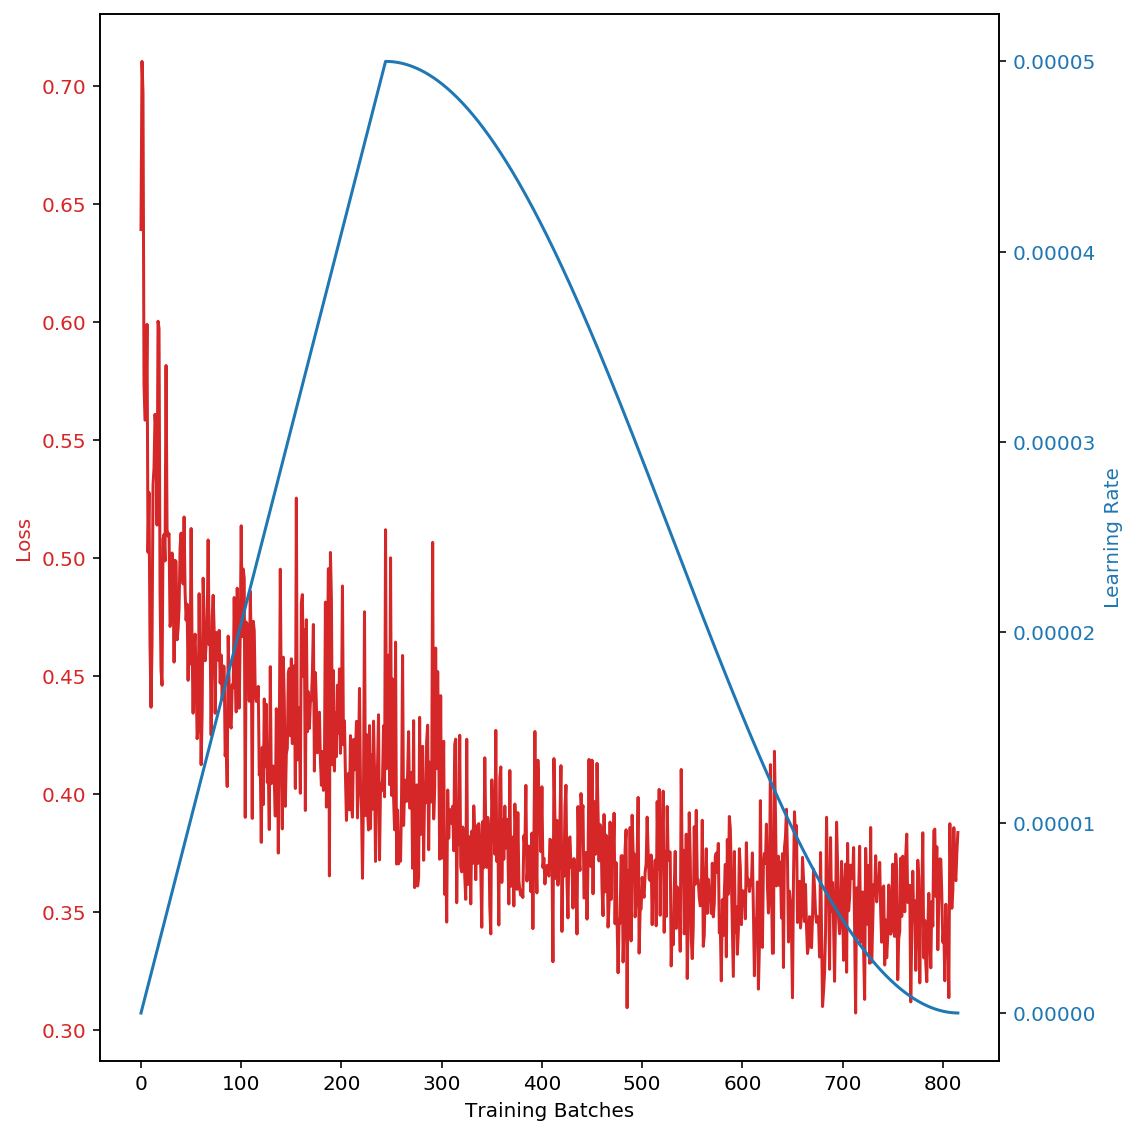

Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.803     0   1
1      0.197 0.838     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.461,"[0.5387405753135681, 0.4612594544887543]",0,0,0.346,"[0.6535692811012268, 0.3464307188987732]",0,0,0.526,"[0.4741441607475281, 0.5258558392524719]",1,1
1,0.512,"[0.48803940415382385, 0.5119606256484985]",1,0,0.458,"[0.541893720626831, 0.45810624957084656]",0,0,0.353,"[0.6469064354896545, 0.35309356451034546]",0,0
2,0.236,"[0.7640123963356018, 0.2359876036643982]",0,0,0.543,"[0.45713672041893005, 0.5428633093833923]",1,1,0.419,"[0.581303060054779, 0.41869691014289856]",0,0
3,0.296,"[0.7043635845184326, 0.29563647508621216]",0,0,0.546,"[0.45423004031181335, 0.5457699298858643]",1,0,0.410,"[0.5898345112800598, 0.4101654887199402]",0,0
4,0.311,"[0.6888871788978577, 0.31111282110214233]",0,0,0.552,"[0.4484262764453888, 0.5515737533569336]",1,1,0.301,"[0.6988435387611389, 0.30115649104118347]",0,1


scores =  {'map': '0.6207', 'acc': '0.5740', 'auc': '0.6471'}


train   val
mean_or_std metric               
mean        map       0.784 0.621
            accuracy  0.767 0.574
            auc       0.856 0.647
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.853  0.768 0.809 5450.000     0.560  0.692 0.619 250.000
pos     0.648  0.764 0.701 3050.000     0.597  0.456 0.517 250.000

In [34]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.851	0.666


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.543452 LR = 0.00000348


Proba       Preds    
         min   max   min max
Labels                      
0      0.244 0.471     0   0
1      0.201 0.525     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.375,"[0.6247873306274414, 0.375212699174881]",0,1,0.334,"[0.6658724546432495, 0.3341275751590729]",0,1,0.364,"[0.6360988020896912, 0.36390116810798645]",0,1
1,0.307,"[0.6933172941207886, 0.3066827654838562]",0,1,0.305,"[0.6949759125709534, 0.305024117231369]",0,0,0.345,"[0.6551291942596436, 0.34487080574035645]",0,1
2,0.362,"[0.637940526008606, 0.36205941438674927]",0,0,0.244,"[0.7561324834823608, 0.24386745691299438]",0,0,0.283,"[0.7172594666481018, 0.2827404737472534]",0,0
3,0.332,"[0.6680145263671875, 0.3319854438304901]",0,0,0.349,"[0.6509459018707275, 0.34905412793159485]",0,0,0.349,"[0.6507447957992554, 0.349255234003067]",0,0
4,0.247,"[0.7531944513320923, 0.24680553376674652]",0,0,0.335,"[0.6653018593788147, 0.3346981406211853]",0,1,0.402,"[0.5983708500862122, 0.40162912011146545]",0,1


scores =  {'map': '0.5442', 'acc': '0.5020', 'auc': '0.5378'}
Epoch =  1 Train = 0.531315 Val = 0.537832



Epoch =  2 Loss = 0.492081 LR = 0.00000697



Epoch =  3 Loss = 0.478720 LR = 0.00001045



Epoch =  4 Loss = 0.458168 LR = 0.00001393


Proba       Preds    
         min   max   min max
Labels                      
0      0.240 0.650     0   1
1      0.334 0.656     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.355,"[0.6450081467628479, 0.3549918830394745]",0,1,0.420,"[0.5802925825119019, 0.41970741748809814]",0,0,0.546,"[0.4540182054042816, 0.545981764793396]",1,0
1,0.469,"[0.5312397480010986, 0.468760222196579]",0,0,0.334,"[0.665682315826416, 0.33431771397590637]",0,1,0.449,"[0.5511736273765564, 0.4488263428211212]",0,1
2,0.458,"[0.542143702507019, 0.45785626769065857]",0,0,0.562,"[0.43764322996139526, 0.56235671043396]",1,1,0.467,"[0.5330632328987122, 0.46693673729896545]",0,0
3,0.437,"[0.5629575252532959, 0.4370424747467041]",0,1,0.334,"[0.666089653968811, 0.33391034603118896]",0,0,0.443,"[0.556640625, 0.443359375]",0,0
4,0.482,"[0.5181804895401001, 0.4818195402622223]",0,1,0.542,"[0.45834869146347046, 0.5416513085365295]",1,0,0.515,"[0.48450204730033875, 0.5154979825019836]",1,1


scores =  {'map': '0.5869', 'acc': '0.5800', 'auc': '0.5851'}
Epoch =  4 Train = 0.665907 Val = 0.585088



Epoch =  5 Loss = 0.452164 LR = 0.00001742



Epoch =  6 Loss = 0.445632 LR = 0.00002090



Epoch =  7 Loss = 0.441186 LR = 0.00002439


Proba       Preds    
         min   max   min max
Labels                      
0      0.106 0.572     0   1
1      0.187 0.611     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.317,"[0.6829438805580139, 0.3170560896396637]",0,1,0.237,"[0.7627003788948059, 0.23729966580867767]",0,0,0.532,"[0.4676964282989502, 0.5323035717010498]",1,1
1,0.338,"[0.6618272662162781, 0.3381727337837219]",0,0,0.355,"[0.6453713774681091, 0.3546285927295685]",0,1,0.276,"[0.7241393327713013, 0.27586066722869873]",0,1
2,0.361,"[0.6388282179832458, 0.36117175221443176]",0,1,0.232,"[0.7684726715087891, 0.23152734339237213]",0,0,0.311,"[0.6892794370651245, 0.3107205033302307]",0,0
3,0.436,"[0.5636932253837585, 0.43630677461624146]",0,1,0.438,"[0.5622666478157043, 0.43773338198661804]",0,1,0.339,"[0.6608926057815552, 0.3391073942184448]",0,1
4,0.428,"[0.5716919302940369, 0.4283081293106079]",0,1,0.412,"[0.5883570909500122, 0.4116429388523102]",0,0,0.438,"[0.5622666478157043, 0.43773338198661804]",0,1


scores =  {'map': '0.6034', 'acc': '0.5280', 'auc': '0.6149'}
Epoch =  7 Train = 0.733041 Val = 0.614936



Epoch =  8 Loss = 0.445694 LR = 0.00002787



Epoch =  9 Loss = 0.437946 LR = 0.00003135


Proba       Preds    
         min   max   min max
Labels                      
0      0.114 0.711     0   1
1      0.232 0.740     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.541,"[0.4586820900440216, 0.5413179397583008]",1,0,0.274,"[0.7255027890205383, 0.27449721097946167]",0,0,0.525,"[0.47487467527389526, 0.5251253247261047]",1,1
1,0.318,"[0.6819385886192322, 0.31806138157844543]",0,0,0.540,"[0.4596521556377411, 0.5403478741645813]",1,1,0.276,"[0.7236024737358093, 0.2763974666595459]",0,1
2,0.714,"[0.2862284779548645, 0.7137715220451355]",1,1,0.288,"[0.7115812301635742, 0.2884187698364258]",0,1,0.538,"[0.46207669377326965, 0.5379233360290527]",1,0
3,0.489,"[0.5113505721092224, 0.4886494278907776]",0,1,0.490,"[0.5096423625946045, 0.4903576374053955]",0,1,0.415,"[0.5853530168533325, 0.4146469831466675]",0,1
4,0.441,"[0.5590173602104187, 0.4409826695919037]",0,0,0.340,"[0.6600354313850403, 0.3399645686149597]",0,1,0.402,"[0.5976996421813965, 0.4023003876209259]",0,0


scores =  {'map': '0.6082', 'acc': '0.5660', 'auc': '0.6207'}
Epoch =  9 Train = 0.751037 Val = 0.620704



Epoch =  10 Loss = 0.416575 LR = 0.00003484



Epoch =  11 Loss = 0.416601 LR = 0.00003832


Proba       Preds    
         min   max   min max
Labels                      
0      0.140 0.737     0   1
1      0.221 0.765     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.576,"[0.4242628812789917, 0.5757371187210083]",1,1,0.430,"[0.5700920224189758, 0.42990797758102417]",0,1,0.559,"[0.4409205913543701, 0.5590794086456299]",1,0
1,0.431,"[0.5686853528022766, 0.43131470680236816]",0,0,0.424,"[0.5757967829704285, 0.4242032766342163]",0,1,0.282,"[0.7176307439804077, 0.28236931562423706]",0,0
2,0.546,"[0.4543662369251251, 0.5456337928771973]",1,1,0.408,"[0.5920181274414062, 0.40798187255859375]",0,1,0.276,"[0.7235537171363831, 0.27644625306129456]",0,0
3,0.274,"[0.725551426410675, 0.27444860339164734]",0,0,0.456,"[0.5438022613525391, 0.4561977684497833]",0,1,0.388,"[0.6122517585754395, 0.3877483010292053]",0,0
4,0.397,"[0.6027632355690002, 0.397236704826355]",0,1,0.292,"[0.7075563073158264, 0.29244372248649597]",0,0,0.381,"[0.6191043257713318, 0.3808956742286682]",0,0


scores =  {'map': '0.6068', 'acc': '0.5740', 'auc': '0.6222'}
Epoch =  11 Train = 0.764615 Val = 0.622200



Epoch =  12 Loss = 0.412013 LR = 0.00004180



Epoch =  13 Loss = 0.421495 LR = 0.00004529



Epoch =  14 Loss = 0.405885 LR = 0.00004877


Proba       Preds    
         min   max   min max
Labels                      
0      0.079 0.697     0   1
1      0.178 0.702     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.458,"[0.5422877073287964, 0.4577123522758484]",0,1,0.496,"[0.5040892958641052, 0.49591073393821716]",0,0,0.421,"[0.5788648724555969, 0.4211351275444031]",0,0
1,0.422,"[0.5783886909484863, 0.42161136865615845]",0,1,0.496,"[0.5038451552391052, 0.4961548447608948]",0,1,0.340,"[0.6603230237960815, 0.33967700600624084]",0,0
2,0.233,"[0.7668179273605347, 0.23318210244178772]",0,1,0.348,"[0.6522344946861267, 0.3477654755115509]",0,0,0.442,"[0.5580108761787415, 0.44198909401893616]",0,0
3,0.496,"[0.5042723417282104, 0.49572762846946716]",0,0,0.420,"[0.5795193910598755, 0.4204805791378021]",0,1,0.371,"[0.628706693649292, 0.3712933361530304]",0,1
4,0.204,"[0.7958961725234985, 0.20410384237766266]",0,0,0.536,"[0.4643550217151642, 0.5356450080871582]",1,0,0.421,"[0.5788648724555969, 0.4211351275444031]",0,1


scores =  {'map': '0.6030', 'acc': '0.5260', 'auc': '0.6229'}
Epoch =  14 Train = 0.782069 Val = 0.622880


Exception for:  keyboard | '' '''' '' | ['word_join' 'sentence_shuffle' 'word_cutout' 'one_third_cut' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  15 Loss = 0.419377 LR = 0.00004995



Epoch =  16 Loss = 0.388671 LR = 0.00004970



Epoch =  17 Loss = 0.402121 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.177 0.852     0   1
1      0.301 0.841     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.553,"[0.44709816575050354, 0.5529018640518188]",1,1,0.415,"[0.584567666053772, 0.4154323637485504]",0,0,0.636,"[0.3644947409629822, 0.635505199432373]",1,1
1,0.628,"[0.37239107489585876, 0.6276088953018188]",1,1,0.499,"[0.5009765625, 0.4990234076976776]",0,1,0.452,"[0.5481293201446533, 0.4518706798553467]",0,1
2,0.425,"[0.5754090547561646, 0.4245908856391907]",0,0,0.509,"[0.49078473448753357, 0.509215235710144]",1,1,0.388,"[0.6117010116577148, 0.38829904794692993]",0,0
3,0.730,"[0.2698183059692383, 0.7301816344261169]",1,0,0.474,"[0.5262818932533264, 0.4737180769443512]",0,1,0.583,"[0.41667795181274414, 0.5833220481872559]",1,0
4,0.814,"[0.18554101884365082, 0.814458966255188]",1,1,0.436,"[0.5635581612586975, 0.43644189834594727]",0,0,0.602,"[0.3977629542350769, 0.6022370457649231]",1,0


scores =  {'map': '0.5896', 'acc': '0.5980', 'auc': '0.6253'}
Epoch =  17 Train = 0.794952 Val = 0.625272



Epoch =  18 Loss = 0.398289 LR = 0.00004856



Epoch =  19 Loss = 0.397575 LR = 0.00004768


Proba       Preds    
         min   max   min max
Labels                      
0      0.056 0.720     0   1
1      0.102 0.661     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.319,"[0.6811040043830872, 0.31889593601226807]",0,0,0.192,"[0.8075365424156189, 0.1924634426832199]",0,0,0.330,"[0.6695811152458191, 0.3304188549518585]",0,1
1,0.166,"[0.8338664174079895, 0.1661335527896881]",0,0,0.226,"[0.773686945438385, 0.22631306946277618]",0,0,0.252,"[0.748467206954956, 0.25153276324272156]",0,0
2,0.270,"[0.7301456332206726, 0.26985442638397217]",0,0,0.332,"[0.6679333448410034, 0.33206668496131897]",0,1,0.295,"[0.7049986124038696, 0.29500138759613037]",0,0
3,0.364,"[0.635505199432373, 0.3644947409629822]",0,1,0.223,"[0.7770249843597412, 0.222974956035614]",0,1,0.329,"[0.6712685823440552, 0.3287314176559448]",0,1
4,0.472,"[0.5278641581535339, 0.4721358120441437]",0,1,0.241,"[0.7594931125640869, 0.24050693213939667]",0,0,0.208,"[0.7922634482383728, 0.20773659646511078]",0,0


scores =  {'map': '0.6110', 'acc': '0.5220', 'auc': '0.6382'}
Epoch =  19 Train = 0.801134 Val = 0.638208



Epoch =  20 Loss = 0.397741 LR = 0.00004660



Epoch =  21 Loss = 0.395762 LR = 0.00004534



Epoch =  22 Loss = 0.381866 LR = 0.00004389



Epoch =  23 Loss = 0.384264 LR = 0.00004229


Proba       Preds    
         min   max   min max
Labels                      
0      0.128 0.736     0   1
1      0.177 0.719     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.507,"[0.4925542175769806, 0.507445752620697]",1,0,0.326,"[0.6735138893127441, 0.32648614048957825]",0,1,0.553,"[0.4472188651561737, 0.5527811646461487]",1,0
1,0.324,"[0.6759116649627686, 0.32408830523490906]",0,1,0.630,"[0.3698838949203491, 0.6301160454750061]",1,1,0.478,"[0.5219585299491882, 0.47804147005081177]",0,0
2,0.386,"[0.613873302936554, 0.38612666726112366]",0,1,0.383,"[0.6173973083496094, 0.3826026916503906]",0,1,0.514,"[0.48590460419654846, 0.5140953660011292]",1,0
3,0.213,"[0.7872368097305298, 0.21276314556598663]",0,1,0.359,"[0.6410432457923889, 0.3589567542076111]",0,0,0.412,"[0.5879727005958557, 0.4120273292064667]",0,0
4,0.484,"[0.515863835811615, 0.4841361939907074]",0,0,0.385,"[0.6153479814529419, 0.3846520781517029]",0,0,0.480,"[0.5198869705200195, 0.4801129996776581]",0,1


scores =  {'map': '0.6082', 'acc': '0.5460', 'auc': '0.6319'}
Epoch =  23 Train = 0.819030 Val = 0.631928



Epoch =  24 Loss = 0.370762 LR = 0.00004053



Epoch =  25 Loss = 0.374427 LR = 0.00003863



Epoch =  26 Loss = 0.370476 LR = 0.00003662



Epoch =  27 Loss = 0.358289 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.106 0.784     0   1
1      0.212 0.775     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.621,"[0.3785165250301361, 0.6214834451675415]",1,1,0.538,"[0.46174484491348267, 0.5382551550865173]",1,1,0.508,"[0.49218812584877014, 0.5078118443489075]",1,0
1,0.636,"[0.36359038949012756, 0.6364096403121948]",1,1,0.462,"[0.5381338000297546, 0.46186619997024536]",0,0,0.516,"[0.483648419380188, 0.5163516402244568]",1,0
2,0.489,"[0.5110455751419067, 0.48895442485809326]",0,1,0.305,"[0.6949306130409241, 0.3050693869590759]",0,1,0.459,"[0.5410451292991638, 0.4589548408985138]",0,1
3,0.353,"[0.6474047303199768, 0.3525952398777008]",0,0,0.381,"[0.6190683841705322, 0.38093167543411255]",0,0,0.444,"[0.5555859208106995, 0.44441407918930054]",0,0
4,0.735,"[0.2650355100631714, 0.7349645495414734]",1,1,0.347,"[0.6525182127952576, 0.34748175740242004]",0,0,0.354,"[0.6463485956192017, 0.35365137457847595]",0,0


scores =  {'map': '0.6104', 'acc': '0.5540', 'auc': '0.6410'}
Epoch =  27 Train = 0.829962 Val = 0.640952



Epoch =  28 Loss = 0.368131 LR = 0.00003231



Epoch =  29 Loss = 0.383766 LR = 0.00003005



Epoch =  30 Loss = 0.370800 LR = 0.00002774



Epoch =  31 Loss = 0.363772 LR = 0.00002541


Proba       Preds    
         min   max   min max
Labels                      
0      0.054 0.799     0   1
1      0.158 0.769     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.398,"[0.6015350222587585, 0.39846494793891907]",0,0,0.430,"[0.5699124932289124, 0.43008747696876526]",0,1,0.409,"[0.590897262096405, 0.40910273790359497]",0,1
1,0.347,"[0.6525458693504333, 0.3474540710449219]",0,1,0.404,"[0.5959630012512207, 0.4040370583534241]",0,0,0.436,"[0.5638583302497864, 0.43614163994789124]",0,0
2,0.563,"[0.4365619719028473, 0.5634379982948303]",1,1,0.331,"[0.6693262457847595, 0.33067378401756287]",0,0,0.270,"[0.7298569083213806, 0.2701431214809418]",0,0
3,0.350,"[0.6495230197906494, 0.3504769504070282]",0,0,0.452,"[0.5476455092430115, 0.45235446095466614]",0,1,0.417,"[0.5833220481872559, 0.41667795181274414]",0,1
4,0.202,"[0.7977932691574097, 0.2022067755460739]",0,1,0.385,"[0.6147409677505493, 0.3852590024471283]",0,0,0.356,"[0.6438613533973694, 0.3561387062072754]",0,1


scores =  {'map': '0.6082', 'acc': '0.5520', 'auc': '0.6409'}
Epoch =  31 Train = 0.836890 Val = 0.640928



Epoch =  32 Loss = 0.367454 LR = 0.00002308



Epoch =  33 Loss = 0.362339 LR = 0.00002076



Epoch =  34 Loss = 0.353546 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.035 0.815     0   1
1      0.158 0.805     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.638,"[0.3618973195552826, 0.6381027102470398]",1,1,0.541,"[0.4588942527770996, 0.5411057472229004]",1,0,0.380,"[0.6199747323989868, 0.38002529740333557]",0,1
1,0.228,"[0.7719832062721252, 0.22801679372787476]",0,1,0.495,"[0.5054929256439209, 0.4945070445537567]",0,0,0.497,"[0.50262451171875, 0.4973755180835724]",0,1
2,0.497,"[0.5028076171875, 0.4971924126148224]",0,0,0.594,"[0.4058607518672943, 0.5941392183303833]",1,1,0.216,"[0.7837402820587158, 0.21625970304012299]",0,1
3,0.504,"[0.49584969878196716, 0.5041502714157104]",1,1,0.409,"[0.5914872884750366, 0.4085127115249634]",0,1,0.532,"[0.4675748348236084, 0.5324251055717468]",1,0
4,0.421,"[0.5791029334068298, 0.42089712619781494]",0,1,0.673,"[0.32715752720832825, 0.6728424429893494]",1,1,0.413,"[0.5869668126106262, 0.4130331575870514]",0,1


scores =  {'map': '0.6122', 'acc': '0.5560', 'auc': '0.6442'}
Epoch =  34 Train = 0.840358 Val = 0.644184



Epoch =  35 Loss = 0.356289 LR = 0.00001626



Epoch =  36 Loss = 0.356441 LR = 0.00001412



Epoch =  37 Loss = 0.362975 LR = 0.00001207


Proba       Preds    
         min   max   min max
Labels                      
0      0.032 0.813     0   1
1      0.170 0.794     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.303,"[0.6971709728240967, 0.3028290271759033]",0,0,0.296,"[0.7043381333351135, 0.29566189646720886]",0,1,0.370,"[0.6302440762519836, 0.3697558641433716]",0,1
1,0.324,"[0.6759518384933472, 0.3240481913089752]",0,0,0.266,"[0.733738124370575, 0.26626187562942505]",0,1,0.147,"[0.8528128862380981, 0.14718705415725708]",0,0
2,0.554,"[0.4464946985244751, 0.5535053014755249]",1,1,0.652,"[0.34800779819488525, 0.65199214220047]",1,0,0.813,"[0.18732771277427673, 0.8126722574234009]",1,0
3,0.440,"[0.5597112774848938, 0.4402887523174286]",0,1,0.577,"[0.42262378334999084, 0.5773762464523315]",1,1,0.316,"[0.6840925812721252, 0.31590741872787476]",0,1
4,0.487,"[0.5133025646209717, 0.4866974651813507]",0,1,0.377,"[0.6232908964157104, 0.37670910358428955]",0,0,0.449,"[0.5509999990463257, 0.44899997115135193]",0,0


scores =  {'map': '0.6186', 'acc': '0.5620', 'auc': '0.6496'}
Epoch =  37 Train = 0.847476 Val = 0.649608



Epoch =  38 Loss = 0.362593 LR = 0.00001013



Epoch =  39 Loss = 0.358154 LR = 0.00000832



Epoch =  40 Loss = 0.350071 LR = 0.00000666



Epoch =  41 Loss = 0.353956 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.042 0.816     0   1
1      0.189 0.818     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.527,"[0.4730486273765564, 0.5269514322280884]",1,0,0.219,"[0.7812471985816956, 0.21875280141830444]",0,1,0.531,"[0.4685474634170532, 0.5314525961875916]",1,0
1,0.315,"[0.6850020289421082, 0.31499800086021423]",0,0,0.391,"[0.6087103486061096, 0.391289621591568]",0,1,0.414,"[0.5862563848495483, 0.41374364495277405]",0,0
2,0.357,"[0.6431612372398376, 0.35683876276016235]",0,0,0.182,"[0.8180474042892456, 0.18195262551307678]",0,0,0.558,"[0.44179341197013855, 0.5582065582275391]",1,0
3,0.464,"[0.536191463470459, 0.46380850672721863]",0,0,0.189,"[0.8114147186279297, 0.18858535587787628]",0,1,0.396,"[0.6037566661834717, 0.3962433636188507]",0,1
4,0.333,"[0.6674187183380127, 0.3325812816619873]",0,0,0.295,"[0.7045922875404358, 0.2954077422618866]",0,0,0.348,"[0.6524905562400818, 0.3475094437599182]",0,1


scores =  {'map': '0.6162', 'acc': '0.5680', 'auc': '0.6456'}
Epoch =  41 Train = 0.851688 Val = 0.645616



Epoch =  42 Loss = 0.358575 LR = 0.00000382



Epoch =  43 Loss = 0.358969 LR = 0.00000268



Epoch =  44 Loss = 0.363042 LR = 0.00000172


Proba       Preds    
         min   max   min max
Labels                      
0      0.040 0.829     0   1
1      0.187 0.821     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.566,"[0.434101402759552, 0.565898597240448]",1,1,0.563,"[0.4372226595878601, 0.5627773404121399]",1,1,0.331,"[0.6692721843719482, 0.33072784543037415]",0,1
1,0.459,"[0.5410451292991638, 0.4589548408985138]",0,1,0.469,"[0.531209409236908, 0.4687906503677368]",0,0,0.368,"[0.6320486664772034, 0.36795133352279663]",0,0
2,0.356,"[0.643609344959259, 0.35639065504074097]",0,0,0.255,"[0.7447375655174255, 0.2552624046802521]",0,1,0.308,"[0.6917057037353516, 0.3082943558692932]",0,0
3,0.333,"[0.6666595935821533, 0.33334043622016907]",0,0,0.482,"[0.5178147554397583, 0.4821853041648865]",0,0,0.305,"[0.6953638792037964, 0.3046360909938812]",0,0
4,0.286,"[0.7139554619789124, 0.2860445976257324]",0,0,0.581,"[0.4186374843120575, 0.5813625454902649]",1,0,0.302,"[0.698445200920105, 0.3015548586845398]",0,1


scores =  {'map': '0.6153', 'acc': '0.5720', 'auc': '0.6474'}
Epoch =  44 Train = 0.853014 Val = 0.647424



Epoch =  45 Loss = 0.356957 LR = 0.00000097



Epoch =  46 Loss = 0.351970 LR = 0.00000043



Epoch =  47 Loss = 0.359306 LR = 0.00000011


Proba       Preds    
         min   max   min max
Labels                      
0      0.044 0.845     0   1
1      0.207 0.839     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.511,"[0.4891374409198761, 0.5108625292778015]",1,1,0.473,"[0.5265862345695496, 0.47341373562812805]",0,1,0.366,"[0.6336910128593445, 0.3663090169429779]",0,1
1,0.331,"[0.6685016751289368, 0.33149832487106323]",0,0,0.440,"[0.5603729486465454, 0.4396270215511322]",0,1,0.720,"[0.28038233518600464, 0.7196177244186401]",1,1
2,0.388,"[0.6117299795150757, 0.3882700502872467]",0,0,0.307,"[0.6934294700622559, 0.30657055974006653]",0,0,0.600,"[0.39992883801460266, 0.6000711917877197]",1,1
3,0.204,"[0.7959754467010498, 0.2040245234966278]",0,0,0.509,"[0.4910287857055664, 0.5089712142944336]",1,0,0.511,"[0.4891374409198761, 0.5108625292778015]",1,0
4,0.548,"[0.4519311189651489, 0.5480688214302063]",1,1,0.377,"[0.6232084631919861, 0.37679150700569153]",0,0,0.450,"[0.5500938296318054, 0.4499061703681946]",0,1


scores =  {'map': '0.6156', 'acc': '0.5680', 'auc': '0.6471'}
Epoch =  47 Train = 0.853276 Val = 0.647080



Epoch =  48 Loss = 0.359604 LR = 0.00000000



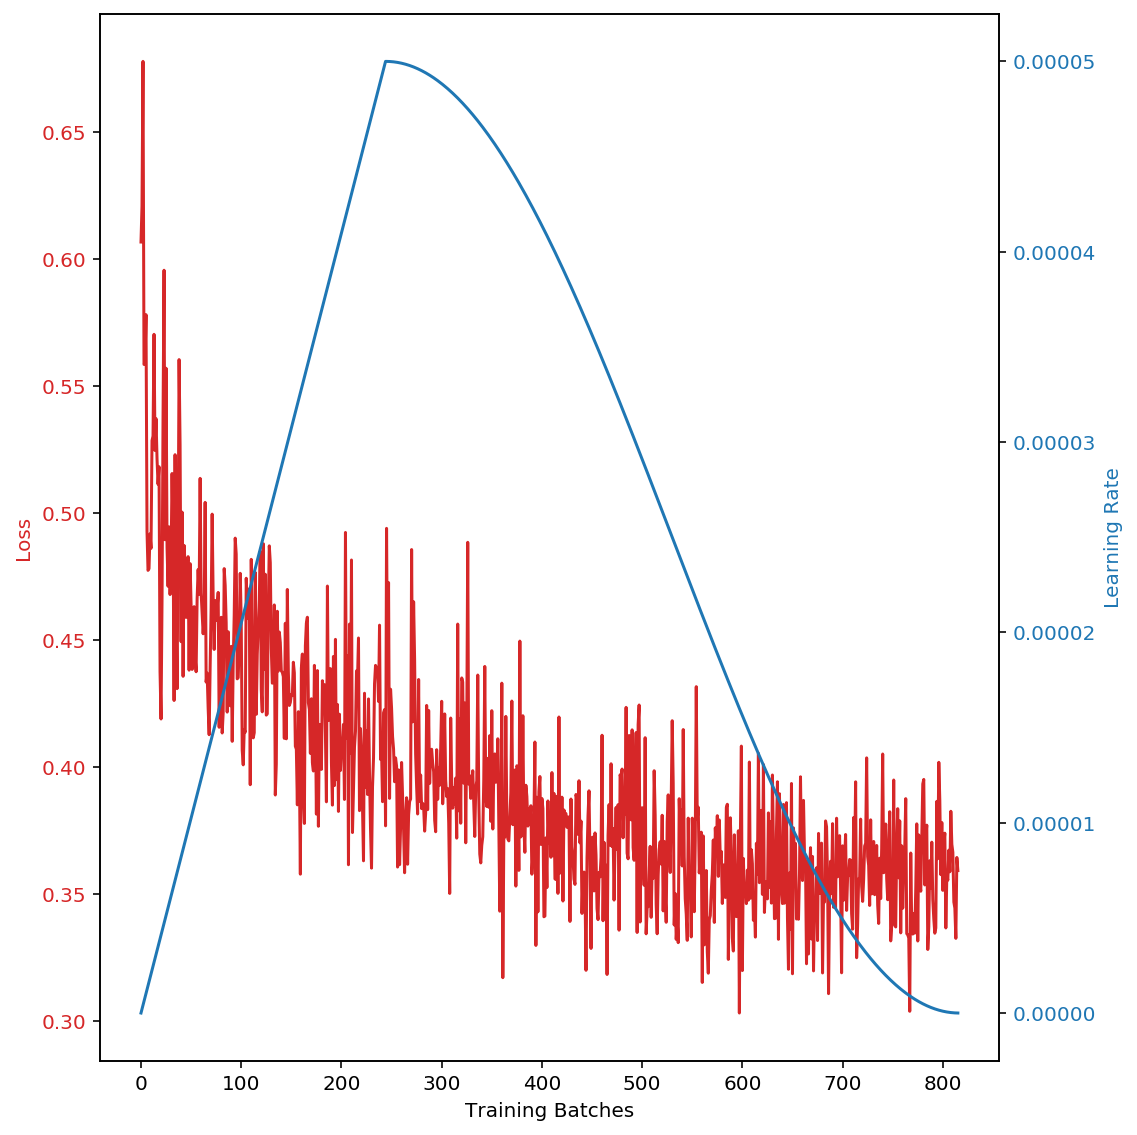

Proba       Preds    
         min   max   min max
Labels                      
0      0.044 0.845     0   1
1      0.207 0.839     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.216,"[0.7838281989097595, 0.21617178618907928]",0,0,0.485,"[0.5150711536407471, 0.4849289059638977]",0,0,0.751,"[0.2489733248949051, 0.7510267496109009]",1,1
1,0.268,"[0.7319216728210449, 0.2680782675743103]",0,1,0.453,"[0.5469196438789368, 0.45308035612106323]",0,1,0.427,"[0.5734395980834961, 0.4265604615211487]",0,1
2,0.548,"[0.45241495966911316, 0.5475850701332092]",1,1,0.561,"[0.439206063747406, 0.560793936252594]",1,0,0.627,"[0.37307605147361755, 0.6269239783287048]",1,1
3,0.416,"[0.5835593938827515, 0.4164406359195709]",0,0,0.571,"[0.42901068925857544, 0.5709893107414246]",1,1,0.583,"[0.41655927896499634, 0.5834407210350037]",1,1
4,0.208,"[0.792182981967926, 0.2078169584274292]",0,0,0.319,"[0.6813691258430481, 0.3186309039592743]",0,0,0.553,"[0.4472792148590088, 0.5527207851409912]",1,0


scores =  {'map': '0.6155', 'acc': '0.5660', 'auc': '0.6470'}


train   val
mean_or_std metric               
mean        map       0.779 0.615
            accuracy  0.770 0.566
            auc       0.853 0.647
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.845  0.784 0.814 5450.000     0.551  0.712 0.621 250.000
pos     0.659  0.743 0.698 3050.000     0.593  0.420 0.492 250.000

In [35]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.02,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs




## Head Ensemble

Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 1.090314 LR = 0.00000348



Epoch =  2 Loss = 0.579400 LR = 0.00000697



Epoch =  3 Loss = 0.499240 LR = 0.00001045



Epoch =  4 Loss = 0.472175 LR = 0.00001393



Epoch =  5 Loss = 0.460100 LR = 0.00001742



Epoch =  6 Loss = 0.448943 LR = 0.00002090



Epoch =  7 Loss = 0.440150 LR = 0.00002439



Epoch =  8 Loss = 0.435833 LR = 0.00002787



Epoch =  9 Loss = 0.416737 LR = 0.00003135



Epoch =  10 Loss = 0.425382 LR = 0.00003484



Epoch =  11 Loss = 0.410842 LR = 0.00003832



Epoch =  12 Loss = 0.407144 LR = 0.00004180



Epoch =  13 Loss = 0.394707 LR = 0.00004529



Epoch =  14 Loss = 0.404215 LR = 0.00004877



Epoch =  15 Loss = 0.393751 LR = 0.00004995



Epoch =  16 Loss = 0.387780 LR = 0.00004970



Epoch =  17 Loss = 0.394705 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.158 0.703     0   1
1      0.229 0.714     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.606,"[0.39357852935791016, 0.6064214706420898]",1,1,0.544,"[0.4557059407234192, 0.5442940592765808]",1,1,0.587,"[0.413485050201416, 0.5865148901939392]",1,0
1,0.280,"[0.7196390628814697, 0.2803608775138855]",0,0,0.446,"[0.5541647672653198, 0.4458352327346802]",0,0,0.678,"[0.3218572735786438, 0.6781426668167114]",1,1
2,0.346,"[0.6544398069381714, 0.34556013345718384]",0,0,0.465,"[0.5348328351974487, 0.4651671350002289]",0,1,0.354,"[0.6461507081985474, 0.3538491725921631]",0,0
3,0.447,"[0.5534974336624146, 0.44650253653526306]",0,0,0.349,"[0.6512153148651123, 0.3487846255302429]",0,1,0.602,"[0.39794787764549255, 0.6020520925521851]",1,1
4,0.587,"[0.41339147090911865, 0.5866084098815918]",1,1,0.498,"[0.5022454261779785, 0.4977545142173767]",0,1,0.402,"[0.5981068015098572, 0.40189313888549805]",0,1


scores =  {'map': '0.6018', 'acc': '0.5440', 'auc': '0.6292'}
Epoch =  17 Train = 0.792374 Val = 0.629152



Epoch =  18 Loss = 0.398551 LR = 0.00004856



Epoch =  19 Loss = 0.387596 LR = 0.00004768



Epoch =  20 Loss = 0.376660 LR = 0.00004660



Epoch =  21 Loss = 0.375519 LR = 0.00004534



Epoch =  22 Loss = 0.378843 LR = 0.00004389



Epoch =  23 Loss = 0.396273 LR = 0.00004229



Epoch =  24 Loss = 0.378691 LR = 0.00004053



Epoch =  25 Loss = 0.371403 LR = 0.00003863



Epoch =  26 Loss = 0.382013 LR = 0.00003662



Epoch =  27 Loss = 0.368392 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.156 0.771     0   1
1      0.235 0.778     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.286,"[0.7139776349067688, 0.2860223948955536]",0,1,0.468,"[0.5316898226737976, 0.46831008791923523]",0,0,0.400,"[0.6003379821777344, 0.3996620178222656]",0,0
1,0.662,"[0.33844736218452454, 0.6615526080131531]",1,0,0.452,"[0.5478515028953552, 0.4521484375]",0,0,0.273,"[0.7272551655769348, 0.2727447748184204]",0,0
2,0.673,"[0.32748985290527344, 0.6725100874900818]",1,0,0.508,"[0.49180370569229126, 0.5081962943077087]",1,0,0.534,"[0.4661395251750946, 0.5338605046272278]",1,0
3,0.413,"[0.586587131023407, 0.41341280937194824]",0,0,0.384,"[0.6155538558959961, 0.38444608449935913]",0,0,0.310,"[0.6902409195899963, 0.30975908041000366]",0,0
4,0.543,"[0.45697712898254395, 0.543022871017456]",1,1,0.468,"[0.5324823260307312, 0.467517614364624]",0,0,0.370,"[0.6297234296798706, 0.3702765107154846]",0,0


scores =  {'map': '0.6237', 'acc': '0.5880', 'auc': '0.6482'}
Epoch =  27 Train = 0.827976 Val = 0.648224



Epoch =  28 Loss = 0.363981 LR = 0.00003231



Epoch =  29 Loss = 0.364714 LR = 0.00003005



Epoch =  30 Loss = 0.363882 LR = 0.00002774



Epoch =  31 Loss = 0.359743 LR = 0.00002541



Epoch =  32 Loss = 0.353261 LR = 0.00002308


Proba       Preds    
         min   max   min max
Labels                      
0      0.094 0.785     0   1
1      0.169 0.770     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.341,"[0.6588448882102966, 0.34115511178970337]",0,0,0.440,"[0.5604722499847412, 0.4395277500152588]",0,0,0.354,"[0.6463762521743774, 0.35362371802330017]",0,1
1,0.276,"[0.7237657904624939, 0.2762342393398285]",0,1,0.502,"[0.497774600982666, 0.5022253394126892]",1,1,0.236,"[0.7644525170326233, 0.2355475276708603]",0,0
2,0.584,"[0.41630327701568604, 0.5836966633796692]",1,1,0.496,"[0.5043346285820007, 0.4956653416156769]",0,1,0.480,"[0.5202885270118713, 0.47971147298812866]",0,1
3,0.196,"[0.8037352561950684, 0.19626472890377045]",0,0,0.377,"[0.6234023571014404, 0.3765975832939148]",0,1,0.458,"[0.5423873662948608, 0.4576126039028168]",0,1
4,0.544,"[0.4558085799217224, 0.5441914200782776]",1,0,0.532,"[0.4679076671600342, 0.532092273235321]",1,1,0.335,"[0.6650210618972778, 0.3349789083003998]",0,0


scores =  {'map': '0.6209', 'acc': '0.5660', 'auc': '0.6514'}
Epoch =  32 Train = 0.841098 Val = 0.651376



Epoch =  33 Loss = 0.368751 LR = 0.00002076



Epoch =  34 Loss = 0.353259 LR = 0.00001849



Epoch =  35 Loss = 0.363162 LR = 0.00001626



Epoch =  36 Loss = 0.347056 LR = 0.00001412



Epoch =  37 Loss = 0.351080 LR = 0.00001207


Proba       Preds    
         min   max   min max
Labels                      
0      0.088 0.883     0   1
1      0.200 0.853     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.504,"[0.49581974744796753, 0.5041802525520325]",1,0,0.652,"[0.3477496802806854, 0.6522502899169922]",1,0,0.370,"[0.6296218037605286, 0.37037813663482666]",0,0
1,0.518,"[0.4822547137737274, 0.5177452564239502]",1,0,0.470,"[0.5301303267478943, 0.4698697328567505]",0,1,0.537,"[0.4626896381378174, 0.5373103618621826]",1,1
2,0.308,"[0.6916741728782654, 0.3083258271217346]",0,1,0.796,"[0.20397675037384033, 0.7960232496261597]",1,0,0.204,"[0.795886754989624, 0.20411323010921478]",0,0
3,0.359,"[0.6409529447555542, 0.3590470850467682]",0,0,0.518,"[0.4822547137737274, 0.5177452564239502]",1,1,0.258,"[0.7423880100250244, 0.2576119899749756]",0,0
4,0.345,"[0.6554139852523804, 0.34458595514297485]",0,0,0.492,"[0.5082348585128784, 0.4917650818824768]",0,1,0.508,"[0.4917462170124054, 0.508253812789917]",1,1


scores =  {'map': '0.6165', 'acc': '0.5820', 'auc': '0.6489'}
Epoch =  37 Train = 0.850526 Val = 0.648912



Epoch =  38 Loss = 0.357669 LR = 0.00001013



Epoch =  39 Loss = 0.353659 LR = 0.00000832



Epoch =  40 Loss = 0.355162 LR = 0.00000666



Epoch =  41 Loss = 0.347912 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.073 0.870     0   1
1      0.168 0.832     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.584,"[0.4156041741371155, 0.5843957662582397]",1,1,0.416,"[0.5842366218566895, 0.41576337814331055]",0,1,0.571,"[0.4287112355232239, 0.5712887048721313]",1,0
1,0.532,"[0.4675910770893097, 0.5324088931083679]",1,0,0.298,"[0.7018647193908691, 0.2981352210044861]",0,1,0.324,"[0.6763719320297241, 0.3236279785633087]",0,0
2,0.668,"[0.3315059244632721, 0.6684939861297607]",1,0,0.416,"[0.5842366218566895, 0.41576337814331055]",0,0,0.471,"[0.529384970664978, 0.470615029335022]",0,0
3,0.422,"[0.5784080028533936, 0.42159193754196167]",0,1,0.146,"[0.8540637493133545, 0.14593622088432312]",0,0,0.261,"[0.7389713525772095, 0.26102858781814575]",0,0
4,0.615,"[0.384746789932251, 0.615253210067749]",1,1,0.537,"[0.46258237957954407, 0.5374175906181335]",1,1,0.384,"[0.6161192655563354, 0.38388076424598694]",0,0


scores =  {'map': '0.6193', 'acc': '0.5780', 'auc': '0.6547'}
Epoch =  41 Train = 0.853522 Val = 0.654736



Epoch =  42 Loss = 0.352394 LR = 0.00000382



Epoch =  43 Loss = 0.349630 LR = 0.00000268



Epoch =  44 Loss = 0.355382 LR = 0.00000172


Proba       Preds    
         min   max   min max
Labels                      
0      0.073 0.849     0   1
1      0.171 0.810     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.236,"[0.7639570236206055, 0.23604297637939453]",0,0,0.336,"[0.6639581918716431, 0.3360418379306793]",0,1,0.491,"[0.5088961720466614, 0.4911038279533386]",0,0
1,0.160,"[0.8401280641555786, 0.1598718762397766]",0,0,0.177,"[0.8225405216217041, 0.1774594783782959]",0,0,0.550,"[0.4496670663356781, 0.5503329634666443]",1,1
2,0.548,"[0.4524547755718231, 0.5475451946258545]",1,0,0.334,"[0.6658688187599182, 0.3341311812400818]",0,1,0.529,"[0.47130531072616577, 0.5286946892738342]",1,1
3,0.849,"[0.15078793466091156, 0.8492120504379272]",1,0,0.495,"[0.5049002766609192, 0.4950997531414032]",0,0,0.426,"[0.5739311575889587, 0.42606884241104126]",0,0
4,0.410,"[0.5900019407272339, 0.4099980592727661]",0,0,0.678,"[0.32171106338500977, 0.6782889366149902]",1,1,0.524,"[0.47640588879585266, 0.523594081401825]",1,1


scores =  {'map': '0.6206', 'acc': '0.5740', 'auc': '0.6548'}
Epoch =  44 Train = 0.855346 Val = 0.654800



Epoch =  45 Loss = 0.352895 LR = 0.00000097



Epoch =  46 Loss = 0.348098 LR = 0.00000043



Epoch =  47 Loss = 0.350416 LR = 0.00000011



Epoch =  48 Loss = 0.346652 LR = 0.00000000



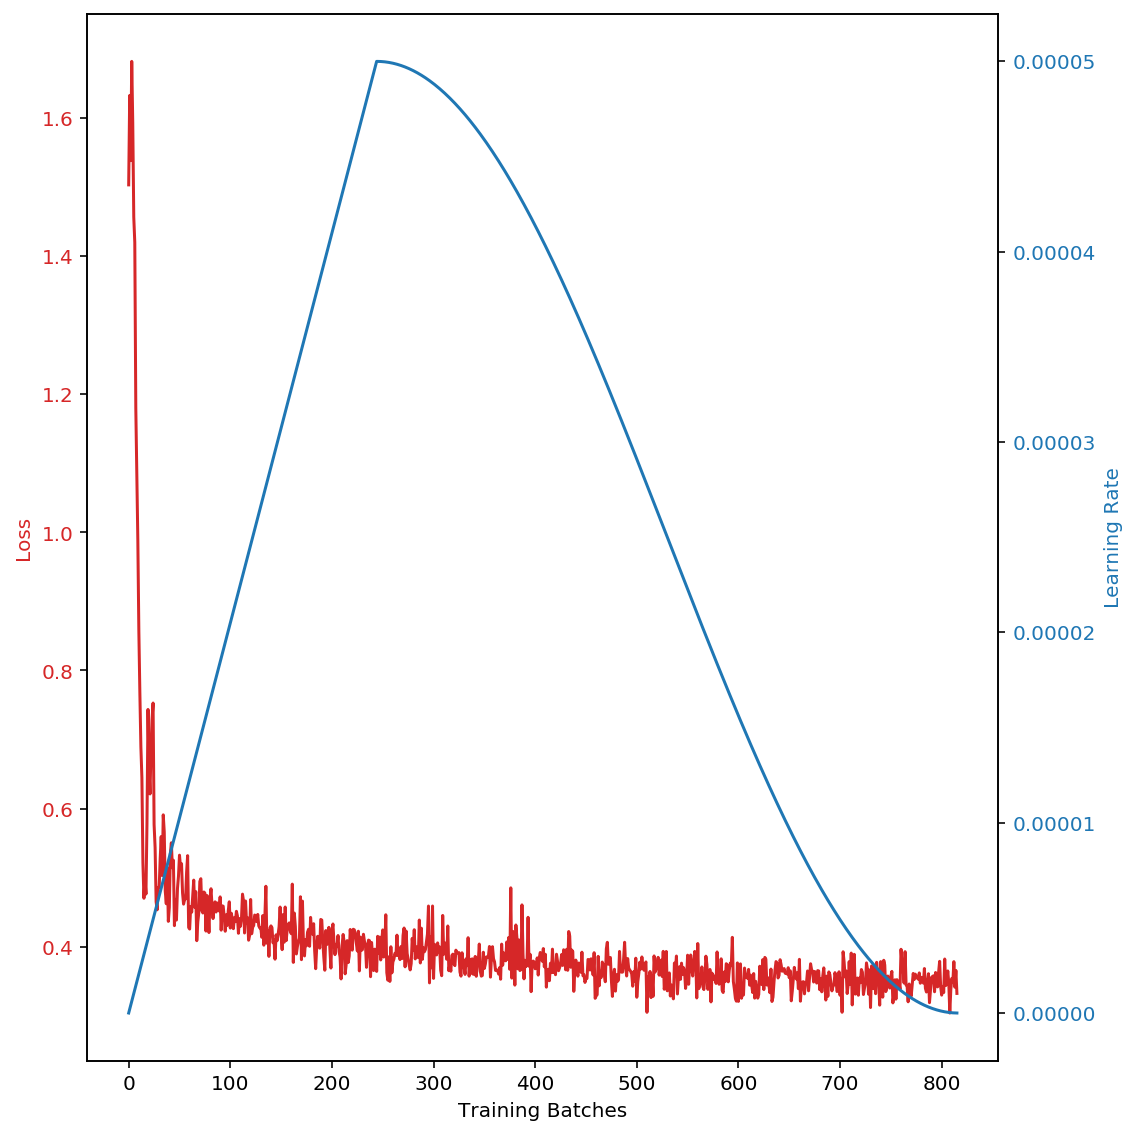

Proba       Preds    
         min   max   min max
Labels                      
0      0.085 0.862     0   1
1      0.193 0.826     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.570,"[0.4300399422645569, 0.5699600577354431]",1,0,0.304,"[0.6959197521209717, 0.30408015847206116]",0,1,0.556,"[0.44400933384895325, 0.5559906363487244]",1,0
1,0.593,"[0.4073828458786011, 0.5926170945167542]",1,0,0.521,"[0.479406476020813, 0.5205935835838318]",1,0,0.657,"[0.34317415952682495, 0.6568257808685303]",1,1
2,0.593,"[0.407461941242218, 0.592538058757782]",1,0,0.370,"[0.6302735209465027, 0.3697264492511749]",0,0,0.296,"[0.704468846321106, 0.29553109407424927]",0,0
3,0.526,"[0.4742478132247925, 0.5257521867752075]",1,1,0.567,"[0.43326276540756226, 0.566737174987793]",1,0,0.354,"[0.6463389992713928, 0.35366106033325195]",0,1
4,0.404,"[0.5961328744888306, 0.40386709570884705]",0,0,0.512,"[0.48834532499313354, 0.5116546750068665]",1,1,0.539,"[0.46122509241104126, 0.538774847984314]",1,1


scores =  {'map': '0.6214', 'acc': '0.5860', 'auc': '0.6544'}


train   val
mean_or_std metric               
mean        map       0.784 0.621
            accuracy  0.770 0.586
            auc       0.856 0.654
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.853  0.775 0.812 5450.000     0.567  0.728 0.637 250.000
pos     0.654  0.761 0.703 3050.000     0.620  0.444 0.517 250.000

In [30]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.05,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs



## Multi-eval Head Ensemble


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 20
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=5, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs

# 0.799	0.657 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.1,
# 0.780	0.634 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.15, 
# 0.806	0.648 gaussian_noise=0.0, dropout=0.02, word_masking_proba=0.1
# 0.803	0.655 gaussian_noise=0.0, dropout=0.1, word_masking_proba=0.1, (0.807	0.657) 0.803	0.653


## Decoder Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.15,
                              word_masking_proba=0.2,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=4,
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=True,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs


In [3]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.01,
                              word_masking_proba=0.1,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-cor-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=1.0,
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs



NameError: name 'torch' is not defined

## Multi-eval decoder ensemble

# Predict

In [7]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.15,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp-v2',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


Pick stored Model /home/ahemf/cache/distilbert-nsp-v2 Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4500 Batch Size =  256
Training Samples =  9000 Weighted Sampling =  True Num Batches =  18 Accumulation steps =  1



Epoch =  1 Loss = 0.813677 LR = 0.00000347



Epoch =  2 Loss = 0.663005 LR = 0.00000695



Epoch =  3 Loss = 0.640369 LR = 0.00001042



Epoch =  4 Loss = 0.630118 LR = 0.00001390



Epoch =  5 Loss = 0.621455 LR = 0.00001737



Epoch =  6 Loss = 0.612866 LR = 0.00002085



Epoch =  7 Loss = 0.598478 LR = 0.00002432



Epoch =  8 Loss = 0.581679 LR = 0.00002780



Epoch =  9 Loss = 0.574211 LR = 0.00003127



Epoch =  10 Loss = 0.559876 LR = 0.00003475



Epoch =  11 Loss = 0.528607 LR = 0.00003822



Epoch =  12 Loss = 0.531500 LR = 0.00004170



Epoch =  13 Loss = 0.515994 LR = 0.00004517



Epoch =  14 Loss = 0.505379 LR = 0.00004865



Epoch =  15 Loss = 0.521665 LR = 0.00004996


Proba       Preds    
         min   max   min max
Labels                      
0      0.114 0.615     0   1
1      0.142 0.615     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.470,"[0.5296629071235657, 0.4703370928764343]",0,1,0.286,"[0.7138770222663879, 0.28612297773361206]",0,1,0.314,"[0.6857767701148987, 0.31422317028045654]",0,0
1,0.302,"[0.697717547416687, 0.3022823929786682]",0,0,0.615,"[0.3848342001438141, 0.6151658296585083]",1,0,0.259,"[0.7412701845169067, 0.2587297856807709]",0,0
2,0.285,"[0.7153017520904541, 0.2846982181072235]",0,0,0.281,"[0.7189252376556396, 0.2810747027397156]",0,0,0.211,"[0.7891688942909241, 0.21083113551139832]",0,0
3,0.253,"[0.7465570569038391, 0.2534428834915161]",0,0,0.314,"[0.6857767701148987, 0.31422317028045654]",0,0,0.268,"[0.7318616509437561, 0.2681383490562439]",0,0
4,0.225,"[0.7753475904464722, 0.22465236485004425]",0,1,0.182,"[0.8184118270874023, 0.18158811330795288]",0,1,0.443,"[0.5572595596313477, 0.44274038076400757]",0,1


scores =  {'map': '0.6037', 'acc': '0.5140', 'auc': '0.6112'}
Epoch =  15 Train = 0.703953 Val = 0.611168



Epoch =  16 Loss = 0.500988 LR = 0.00004972



Epoch =  17 Loss = 0.488920 LR = 0.00004926



Epoch =  18 Loss = 0.498994 LR = 0.00004859



Epoch =  19 Loss = 0.484340 LR = 0.00004771



Epoch =  20 Loss = 0.472404 LR = 0.00004664



Epoch =  21 Loss = 0.465407 LR = 0.00004538



Epoch =  22 Loss = 0.473938 LR = 0.00004394



Epoch =  23 Loss = 0.486017 LR = 0.00004233



Epoch =  24 Loss = 0.456723 LR = 0.00004057



Epoch =  25 Loss = 0.452442 LR = 0.00003868



Epoch =  26 Loss = 0.466463 LR = 0.00003667



Epoch =  27 Loss = 0.450183 LR = 0.00003455



Epoch =  28 Loss = 0.442274 LR = 0.00003235



Epoch =  29 Loss = 0.441136 LR = 0.00003009



Epoch =  30 Loss = 0.430865 LR = 0.00002779



Epoch =  31 Loss = 0.432680 LR = 0.00002545



Epoch =  32 Loss = 0.434187 LR = 0.00002312



Epoch =  33 Loss = 0.438898 LR = 0.00002080



Epoch =  34 Loss = 0.425223 LR = 0.00001852


Proba       Preds    
         min   max   min max
Labels                      
0      0.157 0.731     0   1
1      0.137 0.774     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.561,"[0.4385771155357361, 0.5614228248596191]",1,1,0.542,"[0.45759117603302, 0.54240882396698]",1,1,0.585,"[0.4149949550628662, 0.585004985332489]",1,1
1,0.483,"[0.5172435641288757, 0.48275643587112427]",0,1,0.516,"[0.48445385694503784, 0.5155460834503174]",1,1,0.261,"[0.7392089366912842, 0.26079100370407104]",0,1
2,0.363,"[0.6367393136024475, 0.3632606267929077]",0,0,0.395,"[0.605242908000946, 0.39475709199905396]",0,1,0.461,"[0.5389279127120972, 0.46107202768325806]",0,0
3,0.460,"[0.5403422117233276, 0.45965778827667236]",0,1,0.236,"[0.7644442915916443, 0.2355557382106781]",0,0,0.338,"[0.6617119908332825, 0.33828797936439514]",0,0
4,0.317,"[0.6827528476715088, 0.31724709272384644]",0,0,0.176,"[0.8243767023086548, 0.17562320828437805]",0,0,0.386,"[0.6137391328811646, 0.3862608075141907]",0,0


scores =  {'map': '0.6526', 'acc': '0.5840', 'auc': '0.6635'}
Epoch =  34 Train = 0.744091 Val = 0.663464



Epoch =  35 Loss = 0.423494 LR = 0.00001629



Epoch =  36 Loss = 0.423627 LR = 0.00001414


Exception for:  keyboard | ' ' ' ' | ['word_cutout' 'char_insert' 'one_third_cut' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  37 Loss = 0.417853 LR = 0.00001209



Epoch =  38 Loss = 0.421208 LR = 0.00001015



Epoch =  39 Loss = 0.421487 LR = 0.00000834



Epoch =  40 Loss = 0.421737 LR = 0.00000667



Epoch =  41 Loss = 0.424371 LR = 0.00000516



Epoch =  42 Loss = 0.416787 LR = 0.00000383


Proba       Preds    
         min   max   min max
Labels                      
0      0.108 0.755     0   1
1      0.229 0.757     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.410,"[0.5895992517471313, 0.41040071845054626]",0,0,0.527,"[0.47320878505706787, 0.5267912149429321]",1,1,0.379,"[0.6206896305084229, 0.37931036949157715]",0,1
1,0.327,"[0.6726268529891968, 0.327373206615448]",0,0,0.436,"[0.5638425946235657, 0.4361574053764343]",0,0,0.317,"[0.6825822591781616, 0.3174176812171936]",0,0
2,0.388,"[0.6115865707397461, 0.3884134292602539]",0,1,0.392,"[0.6075395941734314, 0.392460435628891]",0,1,0.259,"[0.7413020133972168, 0.25869789719581604]",0,0
3,0.317,"[0.6831164360046387, 0.31688350439071655]",0,0,0.370,"[0.6297574639320374, 0.37024256587028503]",0,1,0.198,"[0.802187442779541, 0.19781263172626495]",0,0
4,0.507,"[0.4927586317062378, 0.5072413682937622]",1,1,0.755,"[0.24477197229862213, 0.7552280426025391]",1,0,0.533,"[0.4673765003681183, 0.5326235294342041]",1,0


scores =  {'map': '0.6183', 'acc': '0.5620', 'auc': '0.6427'}
Epoch =  42 Train = 0.749118 Val = 0.642688



Epoch =  43 Loss = 0.418871 LR = 0.00000268



Epoch =  44 Loss = 0.421376 LR = 0.00000173



Epoch =  45 Loss = 0.410213 LR = 0.00000098



Epoch =  46 Loss = 0.409540 LR = 0.00000044


Proba       Preds    
         min   max   min max
Labels                      
0      0.154 0.759     0   1
1      0.189 0.851     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.531,"[0.468867689371109, 0.5311323404312134]",1,1,0.398,"[0.6019905805587769, 0.39800938963890076]",0,0,0.391,"[0.6088612079620361, 0.3911387622356415]",0,1
1,0.473,"[0.5274401307106018, 0.4725598692893982]",0,0,0.440,"[0.5599997043609619, 0.4400002360343933]",0,1,0.700,"[0.3004920482635498, 0.6995079517364502]",1,1
2,0.430,"[0.570433497428894, 0.42956656217575073]",0,1,0.416,"[0.5844146013259888, 0.41558539867401123]",0,0,0.330,"[0.6702468395233154, 0.3297531008720398]",0,0
3,0.784,"[0.21574810147285461, 0.784251868724823]",1,1,0.568,"[0.4317716360092163, 0.5682283043861389]",1,0,0.415,"[0.5853890776634216, 0.414610892534256]",0,0
4,0.622,"[0.37787187099456787, 0.6221280694007874]",1,0,0.256,"[0.7442025542259216, 0.2557973861694336]",0,0,0.505,"[0.49458858370780945, 0.5054113864898682]",1,0


scores =  {'map': '0.6526', 'acc': '0.6200', 'auc': '0.6609'}
Epoch =  46 Train = 0.752455 Val = 0.660856



Epoch =  47 Loss = 0.415878 LR = 0.00000011



Epoch =  48 Loss = 0.406519 LR = 0.00000000



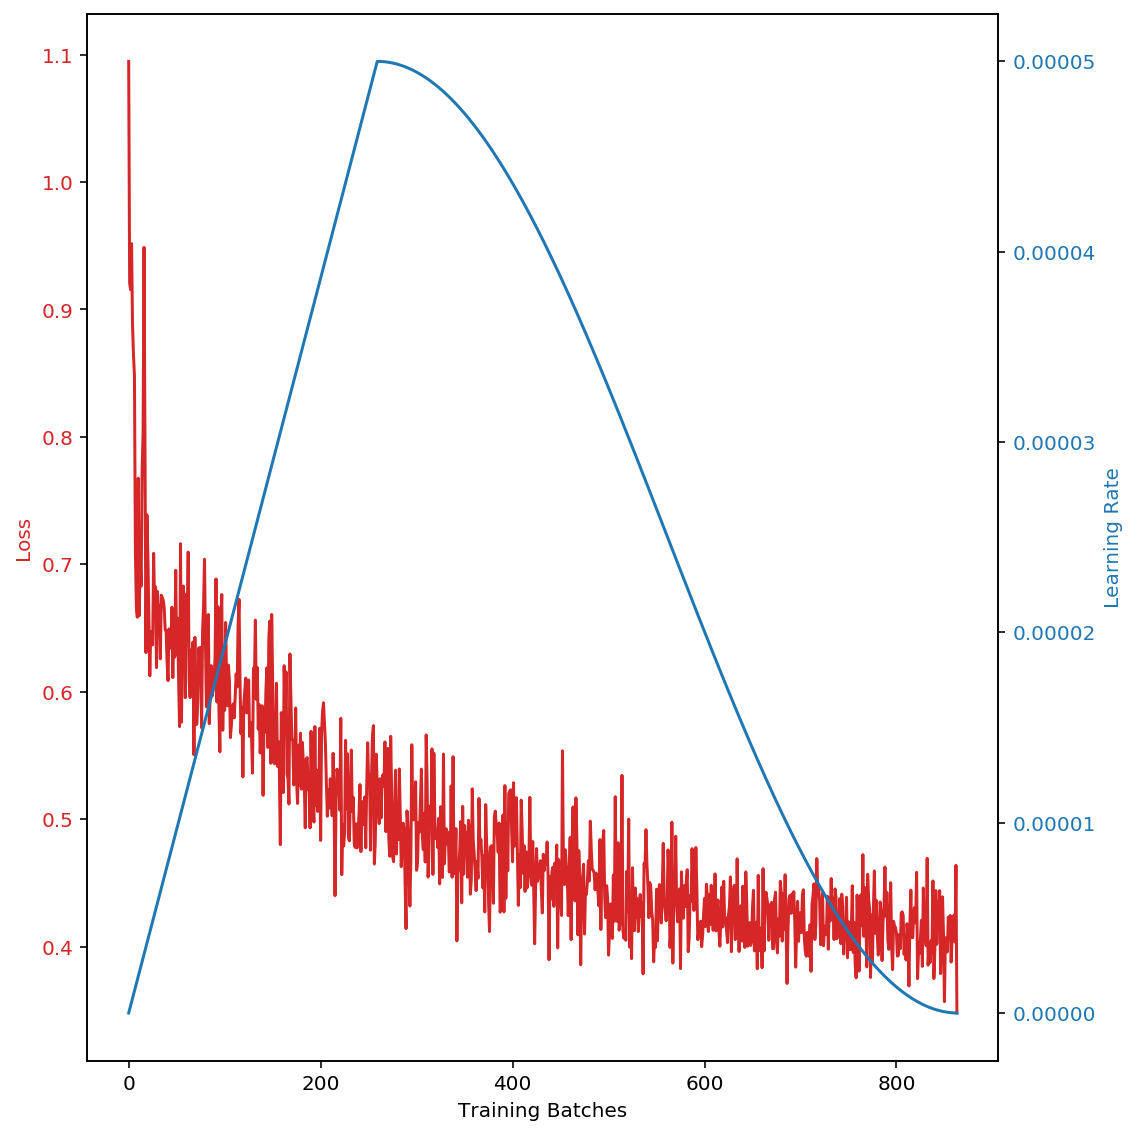

,id,proba,label
498,91736,0.632,1
522,78956,0.428,0
540,69304,0.711,1
948,17805,0.552,1
936,7596,0.653,1


In [8]:
submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 34, 42, 46],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
